# Ising model on a nearest neighbor random graph
This is another example including Ising model where the underlying graph is a random nearest neighbor graph on plane. 

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/.julia/dev/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Model

In this model we will work solely with the graph and won't need agents. We initially create an empty graph and then create our model as follows. 

In [16]:
graph = dynamic_simple_graph(0)

SimplePropGraph
vertices: Int64[]
edges: 


In [17]:
model = create_graph_model(graph, temp = 2.0, coupl = 2.5, nns = 5)

EasyABM GraphModel{Mortal,Static, EasyABM.SimG}: In a {Mortal,Static} model graph topology can change and agents number is fixed.


## Step 2: Initialise the model

 In the `initialiser!` function we create a list of n = 500 random points in the plane and fill our graph with n nodes and set the position of ith node to the ith random point. We then link each node to its `nns` number of nearest neighbors and randomly set each node's color to either `:black` or `:white` and set spin value to +1 for `:black` nodes and -1 for `:white` nodes. In the `init_model!` function the argument `props_to_record` specifies the nodes properties which we want to record during model run. 

In [18]:
using NearestNeighbors

In [19]:
const n=500;

In [20]:
function initialiser!(model)
    vecs = rand(2, n)
    kdtree = KDTree(vecs,leafsize=4)
    flush_graph!(model)
    add_nodes!(n, model, color = :black, spin =1)
    for i in 1:n 
        model.graph.nodesprops[i].pos = (vecs[1,i], vecs[2,i]) # set position of nodes
        indices, _ = knn(kdtree, vecs[:,i], model.parameters.nns, true)
        for j in indices
            if j!=i
                create_edge!(i,j, model)
            end
        end
        if rand()<0.5
            model.graph.nodesprops[i].spin = 1
            model.graph.nodesprops[i].color = :black
        else
            model.graph.nodesprops[i].spin = -1
            model.graph.nodesprops[i].color = :white
        end
    end
end

initialise! (generic function with 1 method)

In [21]:
init_model!(model, initialiser= initialiser!, props_to_record = Dict("nodes"=>[:color, :spin]))

In [ ]:
draw_graph(model.graph)

## Step 3: Run the model

In this step we implement the step logic of the Ising model in the `step_rule!` function and run the model for 100 steps. At each step of the simulation we take 
100 Monte Carlo steps, where in each Monte Carlo step a node is selected at random and its spin and color values are flipped if the Ising energy condition is satisfied. 

In [22]:
function step_rule!(model)
    for i in 1:100
        random_node = rand(1:n)
        spin = model.graph.nodesprops[random_node].spin
        nbr_nodes = neighbor_nodes(random_node, model)
        de = 0.0
        for node in nbr_nodes
            nbr_spin = model.graph.nodesprops[node].spin
            de += spin*nbr_spin
        end
        de = 2*model.parameters.coupl * de
        if (de < 0) || (rand() < exp(-de/model.parameters.temp))
            model.graph.nodesprops[random_node].spin = - spin
            model.graph.nodesprops[random_node].color = spin == -1 ? :black : :white
        end
    end
end

step_rule! (generic function with 1 method)

In [23]:
run_model!(model, steps = 100, step_rule = step_rule!)

In order to draw the model at a specific frame, say 4th, one can use `draw_frame(model, frame = 4)`.  If one wants to see the animation of the model run, it can be done as 

In [ ]:
animate_sim(model)

![png](assets/NNSIsing/NNSIsingAnim1.png)

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [ ]:
create_interactive_app(model, initialiser= initialiser!,
    props_to_record = Dict("nodes"=>[:color, :spin]),
    step_rule= step_rule!,
    model_controls=[(:temp, :s, 0.05:0.05:5.0), 
        (:coupl, :s, 0.01:0.1:5.0),
        (:nns, :s, 2:10)],
    node_plots = Dict("magnetisation"=> x -> x.spin),
    frames=100) 

![png](assets/NNSIsing/NNSIsingIntApp.png)

## Step 4: Fetch Data 

In this step we fetch the data of average spin of nodes (also called magnetisation) and plot the result as follows.

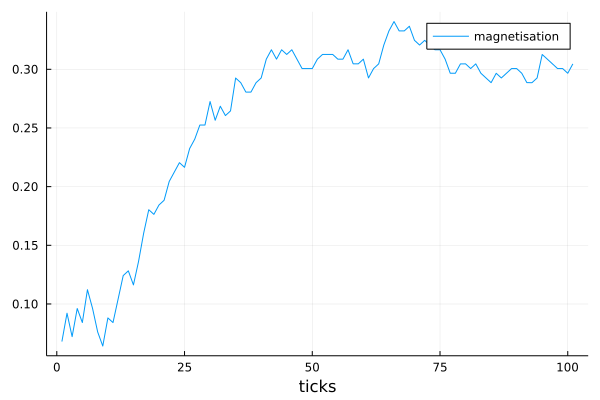

,magnetisation
,Float64
1,0.068
2,0.092136
3,0.0721843
4,0.0961444
5,0.0841923
6,0.112168
7,0.0962243
8,0.0761924
9,0.0641524


In [24]:
df = get_nodes_avg_props(model, node -> node.spin, labels=["magnetisation"], plot_result = true)

![png](assets/NNSIsing/NNSIsingPlot1.png)